In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lv import *

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from flux import *
from xsec import *

from scipy.integrate import quad,dblquad
from scipy.stats import norm
from scipy.interpolate import interp1d,interp2d



In [78]:

# neutrino flavors
alpha = "e"
beta = "e"

In [79]:
Nbaselines = 200
Nenergies = 200
#baselines = np.logspace(1,4.1,Nbaselines)*1e3
baselines = np.logspace(0, np.log10(6.371*2), Nbaselines)*1e6
#energies = np.logspace(-1,3,Nenergies)*1e9
energies = np.logspace(np.log10(Emuon/10), np.log10(Emuon), Nenergies+1)[:-1] * 1e9
SM_cases = []
for baseline in baselines:
    SM_case = LV_oscillations(energies, baseline, 1)
    SM_cases.append(SM_case)

In [80]:
osc_probs_SM = np.zeros((Nbaselines,Nenergies))
for ibaseline,SM_case in enumerate(SM_cases):
    osc_probs_SM[ibaseline,:] = SM_case.get_oscillation_probability(alpha, beta)

In [84]:
# lorentz violation parameters
aeu=0#3e-24*1e9
aet=0#1e-23*1e9
aut=0#3e-24*1e9
ceu=0#1e-27
cet=1e-26
cut=1e-27
LV_cases = []
for baseline in baselines:
    LV_case = LV_oscillations(energies, baseline, 1,
                              aeu = aeu, aet = aet, aut = aut,
                              ceu = ceu, cet = cet, cut = cut)
    LV_cases.append(LV_case)

In [85]:

osc_probs = np.zeros((Nbaselines,Nenergies))
for ibaseline,LV_case in enumerate(LV_cases):
    osc_probs[ibaseline,:] = LV_case.get_oscillation_probability(alpha, beta)


1.0 -26 0.0 0
1.0 -27 0.0 0


Text(617.1051364350253, 6824.54818, 'Chicago\n$\\to$KM3Net')

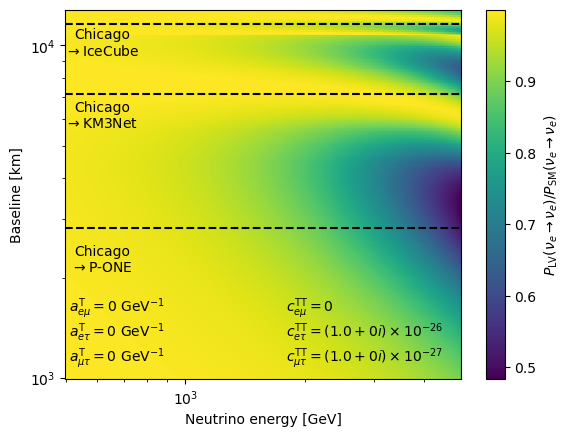

In [88]:
plt.pcolormesh(energies/1e9,baselines/1e3,osc_probs/osc_probs_SM)#,vmin=0,vmax=1)
plt.loglog()
c = plt.colorbar()
plt.xlabel(r"Neutrino energy [GeV]")
plt.ylabel(r"Baseline [km]")
c.set_label(r"$P_{\rm LV}(\nu_{%s} \to \nu_{%s})/P_{\rm SM}(\nu_{%s} \to \nu_{%s})$"%(alpha,beta,alpha,beta))
text_heights = np.linspace(3.05,3.2,3)
text_x_a,text_x_c = 510,1800
plt.text(text_x_a,10**text_heights[2],r"$a^{\rm T}_{e \mu} = %s~{\rm GeV}^{-1}$"%(sci_notation(aeu/1e9) if np.abs(aeu)>0 else "0"))
plt.text(text_x_a,10**text_heights[1],r"$a^{\rm T}_{e \tau} = %s~{\rm GeV}^{-1}$"%(sci_notation(aet/1e9) if np.abs(aet)>0 else "0"))
plt.text(text_x_a,10**text_heights[0],r"$a^{\rm T}_{\mu \tau} = %s~{\rm GeV}^{-1}$"%(sci_notation(aut/1e9) if np.abs(aut)>0 else "0"))
plt.text(text_x_c,10**text_heights[2],r"$c^{\rm TT}_{e \mu} = %s$"%(sci_notation(ceu) if np.abs(ceu)>0 else "0"))
plt.text(text_x_c,10**text_heights[1],r"$c^{\rm TT}_{e \tau} = %s$"%(sci_notation(cet) if np.abs(cet)>0 else "0"))
plt.text(text_x_c,10**text_heights[0],r"$c^{\rm TT}_{\mu \tau} = %s$"%(sci_notation(cut) if np.abs(cut)>0 else "0"))

plt.axhline(ICECUBE_BASELINE/1e3, color="black", linestyle="--")
plt.axhline(PONE_BASELINE/1e3, color="black", linestyle="--")
plt.axhline(KM3NeT_BASELINE/1e3, color="black", linestyle="--")

plt.text(plt.xlim()[0] + 120, ICECUBE_BASELINE/1e3 - 300,'Chicago\n$\\to$IceCube', verticalalignment="top", horizontalalignment="center")
plt.text(plt.xlim()[0] + 120, PONE_BASELINE/1e3 - 300,'Chicago\n$\\to$P-ONE', verticalalignment="top", horizontalalignment="center")
plt.text(plt.xlim()[0] + 120, KM3NeT_BASELINE/1e3 - 300,'Chicago\n$\\to$KM3Net', verticalalignment="top", horizontalalignment="center")

# Rate calculations under different hypotheses

In [9]:
# Rate of neutrino interactions / dR / dE
# Units: (Number of Interactions) / m / GeV
def rate(flux, xsec, Enu, R, P, baseline):
    costh = np.cos(R/baseline)
    ret = flux(Emuon, P, Enu, costh, baseline)*xsec(Enu)*MASS*(4*np.pi*R*np.sqrt(RADIUS**2 - R**2)/VOLUME)
    if not isinstance(ret, float):
        ret[R > RADIUS] = 0
    elif R > RADIUS:
        return 0
    return ret

def numu_rate(Enu, R, P, B):
    return rate(numu_flux_baseline, xsec, Enu, R, P, B)

def nue_rate(Enu, R, P, B):
    return rate(nue_flux_baseline, xsec, Enu, R, P, B)

def numubar_rate(Enu, R, P, B):
    return rate(numu_flux_baseline, xsecbar, Enu, R, P, B)

def nuebar_rate(Enu, R, P, B):
    return rate(nue_flux_baseline, xsecbar, Enu, R, P, B)

In [97]:
Enu = np.linspace(Emuon/100, Emuon, 100)
Rs = np.linspace(0,RADIUS,101)

In [11]:
rates_per_energy = {}
rates_per_radius_SM = {}
rates_per_radius_LV = {}
rate_functions = {}
experiment_list = ["KM3","IC","PONE"]
particle_list = ["numubar","nue"]
baseline_list = {"PONE":PONE_BASELINE,
                 "KM3":KM3NeT_BASELINE,
                 "IC":ICECUBE_BASELINE}
LV_case_list = {}
SM_case_list = {}
for experiment in experiment_list:
    LV_case_list[("nu",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], 1,
                                                      aeu = aeu, aet = aet, aut = aut,
                                                      ceu = ceu, cet = cet, cut = cut)
    LV_case_list[("nubar",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], -1,
                                                      aeu = aeu, aet = aet, aut = aut,
                                                      ceu = ceu, cet = cet, cut = cut)
    SM_case_list[("nu",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], 1,
                                                      aeu = 0, aet = 0, aut = 0,
                                                      ceu = 0, cet = 0, cut = 0)
    SM_case_list[("nubar",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], -1,
                                                      aeu = 0, aet = 0, aut = 0,
                                                      ceu = 0, cet = 0, cut = 0)
for particle,rate_function in zip(["numu","numubar","nue","nuebar"],
                                  [numu_rate,numubar_rate,nue_rate,nuebar_rate]):
    rate_functions[particle] = rate_function
    for experiment in experiment_list:
        rates_per_energy[(particle,experiment)] = np.zeros(Enu.shape)
        rates_per_radius_SM[(particle,experiment)] = np.zeros(Rs.shape)
        rates_per_radius_LV[(particle,experiment)] = np.zeros(Rs.shape)


for particle in particle_list:
    for experiment in experiment_list:
        for i,E in enumerate(Enu):
            rates_per_energy[(particle,experiment)][i] = quad(lambda R: rate_functions[particle](E, R, P, baseline_list[experiment]), 0, RADIUS)[0]

# now do the radial distributions
for experiment in experiment_list:
    for i, R in enumerate(Rs):
        SM_mu_mu_osc = interp1d(Enu, SM_case_list[("nubar",experiment)].get_oscillation_probability("mu","mu",R=R))
        SM_mu_e_osc = interp1d(Enu, SM_case_list[("nubar",experiment)].get_oscillation_probability("mu","e",R=R))
        SM_e_e_osc = interp1d(Enu, SM_case_list[("nu",experiment)].get_oscillation_probability("e","e",R=R))
        SM_e_mu_osc = interp1d(Enu, SM_case_list[("nu",experiment)].get_oscillation_probability("e","mu",R=R))
        LV_mu_mu_osc = interp1d(Enu, LV_case_list[("nubar",experiment)].get_oscillation_probability("mu","mu",R=R))
        LV_mu_e_osc = interp1d(Enu, LV_case_list[("nubar",experiment)].get_oscillation_probability("mu","e",R=R))
        LV_e_e_osc = interp1d(Enu, LV_case_list[("nu",experiment)].get_oscillation_probability("e","e",R=R))
        LV_e_mu_osc = interp1d(Enu, LV_case_list[("nu",experiment)].get_oscillation_probability("e","mu",R=R))
        rates_per_radius_SM[("numubar",experiment)][i] = quad(lambda E: rate_functions["numubar"](E, R, P, baseline_list[experiment]) * SM_mu_mu_osc(E) + rate_functions["nue"](E, R, P, baseline_list[experiment]) * SM_e_mu_osc(E), Enu[0], Enu[-1])[0]
        rates_per_radius_SM[("nue",experiment)][i] = quad(lambda E: rate_functions["nue"](E, R, P, baseline_list[experiment]) * SM_e_e_osc(E) + rate_functions["numubar"](E, R, P, baseline_list[experiment]) * SM_mu_e_osc(E), Enu[0], Enu[-1])[0]
        rates_per_radius_LV[("numubar",experiment)][i] = quad(lambda E: rate_functions["numubar"](E, R, P, baseline_list[experiment]) * LV_mu_mu_osc(E) + rate_functions["nue"](E, R, P, baseline_list[experiment]) * LV_e_mu_osc(E), Enu[0], Enu[-1])[0]
        rates_per_radius_LV[("nue",experiment)][i] = quad(lambda E: rate_functions["nue"](E, R, P, baseline_list[experiment]) * LV_e_e_osc(E) + rate_functions["numubar"](E, R, P, baseline_list[experiment]) * LV_mu_e_osc(E), Enu[0], Enu[-1])[0]
        
        

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/3068576.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rates_per_energy[(particle,experiment)][i] = quad(lambda R: rate_functions[particle](E, R, P, baseline_list[experiment]), 0, RADIUS)[0]
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/3068576.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rates_per_energy[(particle,experiment)][i] = quad(lambda R: rate_functions[pa

# Energy Distributions

1.0 -26 0.0 0


/Users/nickkamp/Documents/Harvard/Research/Fun/Gray_MuonColliderIceCube/NuTelescopeMuCollider/lv.py:164: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(Enu/1e3,rates_per_energy_LV[experiment]/rates_per_energy_SM[experiment],color=color)


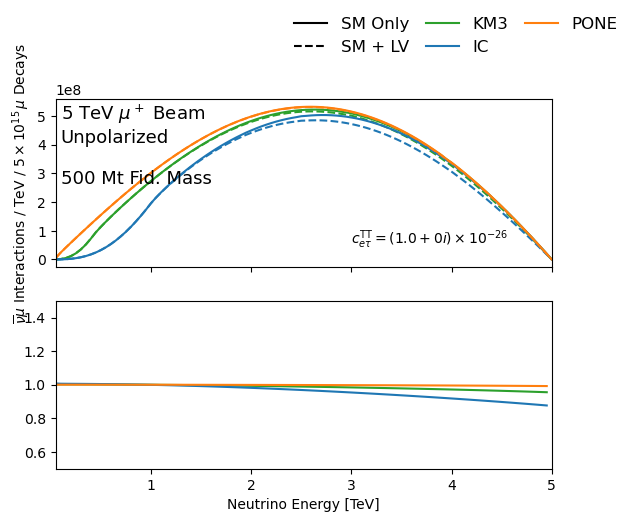

1.0 -26 0.0 0


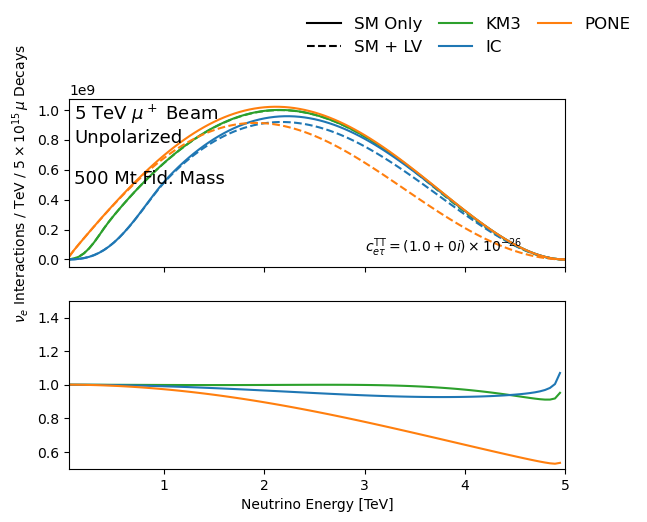

In [12]:
numubar_rates_per_energy_SM = {}
numubar_rates_per_energy_LV = {}
nue_rates_per_energy_SM = {}
nue_rates_per_energy_LV = {}

for experiment in experiment_list:
    numubar_rate = rates_per_energy[("numubar",experiment)]
    nue_rate = rates_per_energy[("nue",experiment)]

    # numubars
    mu_to_mu_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu") * numubar_rate
    mu_to_mu_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu") * numubar_rate
    e_to_mu_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "mu") * nue_rate
    e_to_mu_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "mu") * nue_rate
    numubar_rates_per_energy_SM[experiment] = mu_to_mu_SM + e_to_mu_SM
    numubar_rates_per_energy_LV[experiment] = mu_to_mu_LV + e_to_mu_LV

    # nues
    mu_to_e_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e") * numubar_rate
    mu_to_e_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e") * numubar_rate
    e_to_e_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "e") * nue_rate
    e_to_e_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "e") * nue_rate
    nue_rates_per_energy_SM[experiment] = mu_to_e_SM + e_to_e_SM
    nue_rates_per_energy_LV[experiment] = mu_to_e_LV + e_to_e_LV
    
energy_plot_1D(Enu,Emuon,
               experiment_list,
               numubar_rates_per_energy_SM,
               numubar_rates_per_energy_LV,
               r"\overline{\nu}\mu",cet=cet)

energy_plot_1D(Enu,Emuon,
               experiment_list,
               nue_rates_per_energy_SM,
               nue_rates_per_energy_LV,
               r"\nu_e",cet=cet)


# Radius

1.0 -26 0.0 0


/Users/nickkamp/Documents/Harvard/Research/Fun/Gray_MuonColliderIceCube/NuTelescopeMuCollider/lv.py:206: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(Rs,rates_per_radius_LV[(nutype,experiment)]/rates_per_radius_SM[(nutype,experiment)],color=color)


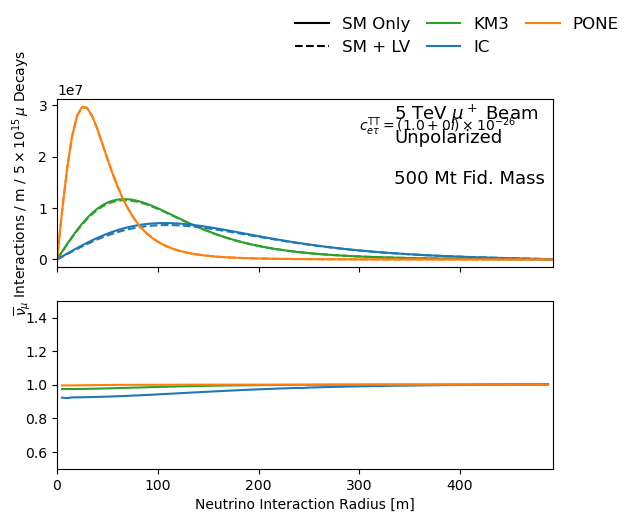

1.0 -26 0.0 0


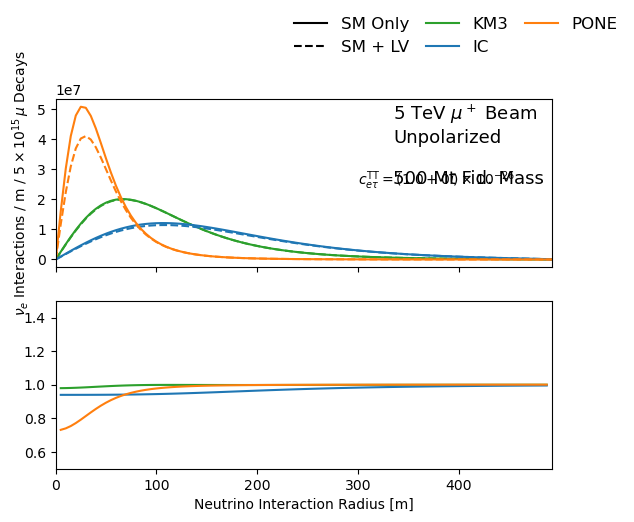

In [13]:
# numubars
radial_plot_1D(Rs,Emuon,
               experiment_list,
               rates_per_radius_SM,
               rates_per_radius_LV,
               "numubar",r"\overline{\nu}_\mu",
               cet=cet)
radial_plot_1D(Rs,Emuon,
               experiment_list,
               rates_per_radius_SM,
               rates_per_radius_LV,
               "nue",r"\nu_e",
               cet=cet)
               

# 2D reco binned distribution

In [98]:
# lorentz violation parameters
aeu=0#3e-24*1e9
aet=0#1e-23*1e9
aut=0#3e-24*1e9
ceu=0#1e-27
cet=1e-27
cut=0#1e-27

LV_case_list = {}
SM_case_list = {}
for experiment in experiment_list:
    LV_case_list[("nu",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], 1,
                                                      aeu = aeu, aet = aet, aut = aut,
                                                      ceu = ceu, cet = cet, cut = cut)
    LV_case_list[("nubar",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], -1,
                                                      aeu = aeu, aet = aet, aut = aut,
                                                      ceu = ceu, cet = cet, cut = cut)
    SM_case_list[("nu",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], 1,
                                                      aeu = 0, aet = 0, aut = 0,
                                                      ceu = 0, cet = 0, cut = 0)
    SM_case_list[("nubar",experiment)] = LV_oscillations(Enu*1e9, baseline_list[experiment], -1,
                                                      aeu = 0, aet = 0, aut = 0,
                                                      ceu = 0, cet = 0, cut = 0)

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1503227520.py:49: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(Enu,Rs,(numubar_rates_per_energy_radius_LV[experiment]/numubar_rates_per_energy_radius_SM[experiment]).T,vmin=0.999,vmax=1)
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1503227520.py:50: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


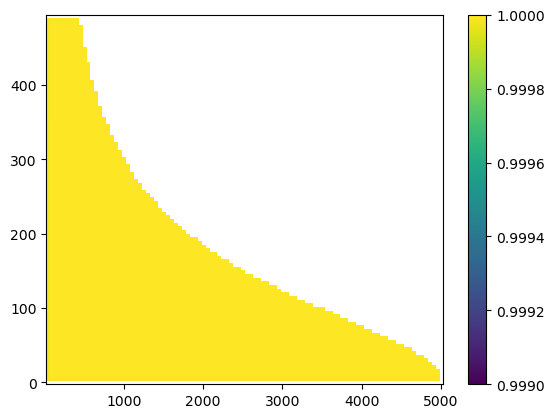

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1503227520.py:52: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(Enu,Rs,(nue_rates_per_energy_radius_LV[experiment]/nue_rates_per_energy_radius_SM[experiment]).T,vmin=0.999,vmax=1)
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1503227520.py:53: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


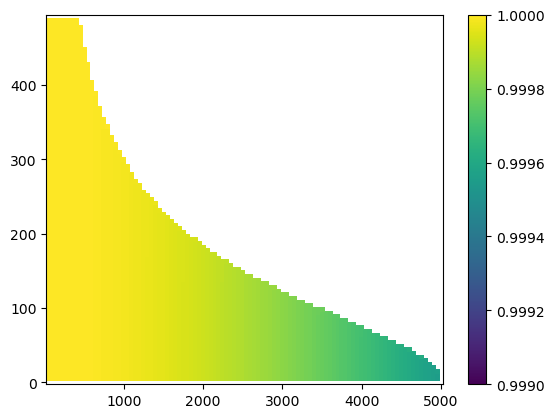

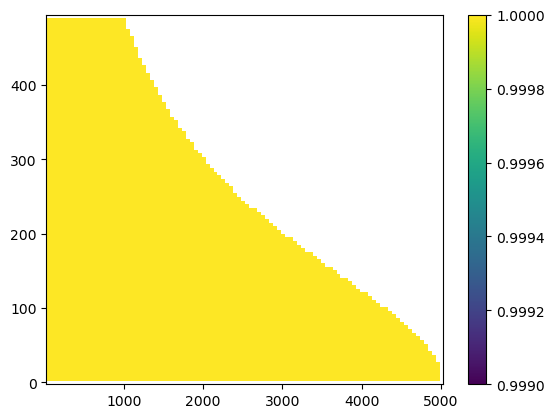

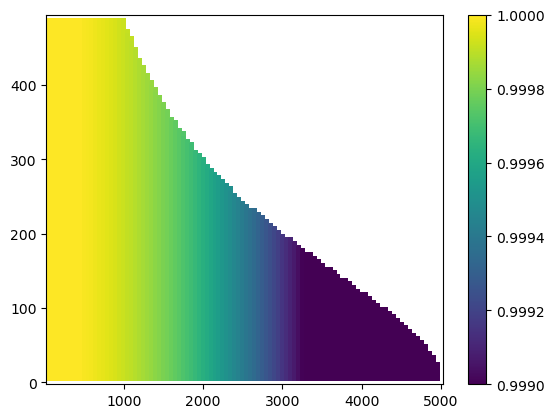

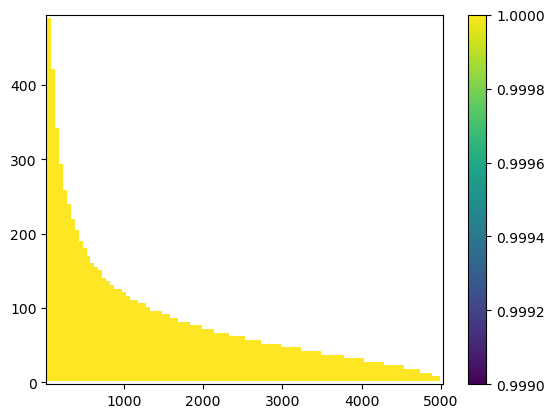

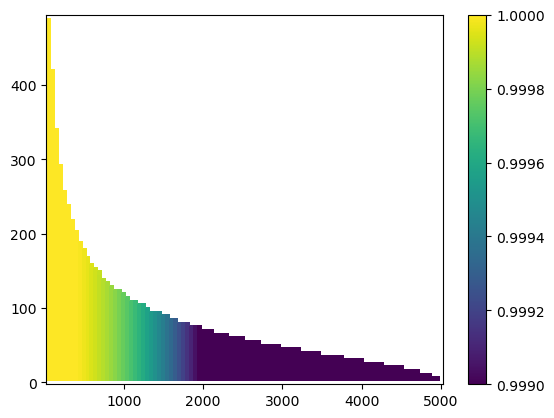

In [100]:


numubar_rates_per_energy_radius_SM = {}
numubar_rates_per_energy_radius_LV = {}
nue_rates_per_energy_radius_SM = {}
nue_rates_per_energy_radius_LV = {}

numubar_interp_rates_per_energy_radius_SM = {}
numubar_interp_rates_per_energy_radius_LV = {}
nue_interp_rates_per_energy_radius_SM = {}
nue_interp_rates_per_energy_radius_LV = {}

numubar_interp_total_rates_SM = {}
numubar_interp_total_rates_LV = {}
nue_interp_total_rates_SM = {}
nue_interp_total_rates_LV = {}



numubar_rate = rate_functions['numubar']
nue_rate = rate_functions['nue']

for experiment in experiment_list:
    numubar_rates_per_energy_radius_SM[experiment] = np.zeros((len(Enu),len(Rs)))
    numubar_rates_per_energy_radius_LV[experiment] = np.zeros((len(Enu),len(Rs)))
    nue_rates_per_energy_radius_SM[experiment] = np.zeros((len(Enu),len(Rs)))
    nue_rates_per_energy_radius_LV[experiment] = np.zeros((len(Enu),len(Rs)))
    
    for ir,R in enumerate(Rs):
        # numubars
        mu_to_mu_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu",R=R)
        mu_to_mu_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "mu",R=R)
        e_to_mu_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "mu",R=R)
        e_to_mu_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "mu",R=R)
    
        # nues
        mu_to_e_LV = LV_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e",R=R)
        mu_to_e_SM = SM_case_list[("nubar",experiment)].get_oscillation_probability("mu", "e",R=R)
        e_to_e_LV = LV_case_list[("nu",experiment)].get_oscillation_probability("e", "e",R=R)
        e_to_e_SM = SM_case_list[("nu",experiment)].get_oscillation_probability("e", "e",R=R)
        for ie,E in enumerate(Enu):
            numubar_rates_per_energy_radius_SM[experiment][ie,ir] = mu_to_mu_SM[ie] * numubar_rate(E, R, P, baseline_list[experiment]) + e_to_mu_SM[ie] * nue_rate(E, R, P, baseline_list[experiment])
            numubar_rates_per_energy_radius_LV[experiment][ie,ir] = mu_to_mu_LV[ie] * numubar_rate(E, R, P, baseline_list[experiment]) + e_to_mu_LV[ie] * nue_rate(E, R, P, baseline_list[experiment])
            nue_rates_per_energy_radius_SM[experiment][ie,ir] = e_to_e_SM[ie] * nue_rate(E, R, P, baseline_list[experiment]) + mu_to_e_SM[ie] * numubar_rate(E, R, P, baseline_list[experiment])
            nue_rates_per_energy_radius_LV[experiment][ie,ir] = e_to_e_LV[ie] * nue_rate(E, R, P, baseline_list[experiment]) + mu_to_e_LV[ie] * numubar_rate(E, R, P, baseline_list[experiment])
    numubar_interp_rates_per_energy_radius_SM[experiment] = RegularGridInterpolator((Enu,Rs),numubar_rates_per_energy_radius_SM[experiment])
    numubar_interp_rates_per_energy_radius_LV[experiment] = RegularGridInterpolator((Enu,Rs),numubar_rates_per_energy_radius_LV[experiment])
    nue_interp_rates_per_energy_radius_SM[experiment] = RegularGridInterpolator((Enu,Rs),nue_rates_per_energy_radius_SM[experiment])
    nue_interp_rates_per_energy_radius_LV[experiment] = RegularGridInterpolator((Enu,Rs),nue_rates_per_energy_radius_LV[experiment])
    
    plt.pcolor(Enu,Rs,(numubar_rates_per_energy_radius_LV[experiment]/numubar_rates_per_energy_radius_SM[experiment]).T,vmin=0.999,vmax=1)
    plt.colorbar()
    plt.show()
    plt.pcolor(Enu,Rs,(nue_rates_per_energy_radius_LV[experiment]/nue_rates_per_energy_radius_SM[experiment]).T,vmin=0.999,vmax=1)
    plt.colorbar()
    plt.show()
    
    # numubar_interp_total_rates_SM[experiment] = dblquad(lambda E,R: numubar_interp_rates_per_energy_radius_SM[experiment]((E,R)),Rs[0],Rs[-1],Enu[0],Enu[-1])
    # numubar_interp_total_rates_LV[experiment] = dblquad(lambda E,R: numubar_interp_rates_per_energy_radius_LV[experiment]((E,R)),Rs[0],Rs[-1],Enu[0],Enu[-1])
    # nue_interp_total_rates_SM[experiment] = dblquad(lambda E,R: nue_interp_rates_per_energy_radius_SM[experiment]((E,R)),Rs[0],Rs[-1],Enu[0],Enu[-1])
    # nue_interp_total_rates_LV[experiment] = dblquad(lambda E,R: nue_interp_rates_per_energy_radius_LV[experiment]((E,R)),Rs[0],Rs[-1],Enu[0],Enu[-1])
    
            
            
        
        

In [101]:
import vegas

def NueEnergySmearing(Ereco,Etrue,kE=0.1/np.log10(np.e)):
    return norm.pdf(Ereco,loc=Etrue,scale=kE*Etrue)

def NumuEnergySmearing(Ereco,Etrue,kE=0.5):
    return norm.pdf(Ereco,loc=Etrue,scale=kE*Etrue)

def PositionSmearing(Rreco,Rtrue,sig_r=10):
    return norm.pdf(Rreco,loc=Rtrue,scale=sig_r)
    
@vegas.rbatchintegrand
def nue_integrand(x):
    Er,Rr,Et = x
    Rt = Rr
    #Et = Er
    ret = {}
    for experiment in experiment_list:
        ret[(experiment,"SM")] = nue_interp_rates_per_energy_radius_SM[experiment]((Et,Rt))*NueEnergySmearing(Er,Et)#*PositionSmearing(Rr,Rt)
        ret[(experiment,"LV")] = nue_interp_rates_per_energy_radius_LV[experiment]((Et,Rt))*NueEnergySmearing(Er,Et)#*PositionSmearing(Rr,Rt)
    return ret

@vegas.rbatchintegrand
def numu_integrand(x):
    Et,Rr = x
    Rt = Rr
    ret = {}
    for experiment in experiment_list:
        ret[(experiment,"SM")] = numubar_interp_rates_per_energy_radius_SM[experiment]((Et,Rt))#*PositionSmearing(Rr,Rt)
        ret[(experiment,"LV")] = numubar_interp_rates_per_energy_radius_LV[experiment]((Et,Rt))#*PositionSmearing(Rr,Rt)
    return ret

def trapezoid_integrate(Rbins,Ebins,oversampling=10):
    numu_rates_per_bin = {(exp,k):np.zeros(len(Rbins)-1) for exp in experiment_list for k in ["SM","LV"]} # radial bins 
    nue_rates_per_bin = {(exp,k):np.zeros((len(Ebins)-1,len(Rbins)-1)) for exp in experiment_list for k in ["SM","LV"]} # energy x radial bins
    for iR in range(len(Rbins)-1):
        r_subrange = np.linspace(Rbins[iR],Rbins[iR+1],oversampling)
        e_subrange = np.linspace(Ebins[0],Ebins[-1],len(Ebins)*oversampling) # integerate numu over full e range
        X,Y = np.meshgrid(e_subrange,r_subrange)
        numu_diff_rates = numu_integrand((X,Y))
        for exp in experiment_list:
            for k in ["SM","LV"]:
                numu_rate = np.trapz(np.trapz(numu_diff_rates[(exp,k)], r_subrange, axis=0), e_subrange, axis=0)
                numu_rates_per_bin[(exp,k)][iR] = numu_rate
        for iE in range(len(Ebins)-1):
            e_subrange = np.linspace(Ebins[iE],Ebins[iE+1],oversampling) # integerate nue over only e bin
            etrue_subrange = np.linspace(Ebins[0],Ebins[-1],len(Ebins)*oversampling) # integrate over etrue as well for energy smearing
            X,Y,Z = np.meshgrid(e_subrange,r_subrange,etrue_subrange)
            nue_diff_rates = nue_integrand((X,Y,Z))
            for exp in experiment_list:
                for k in ["SM","LV"]:
                    nue_rate = np.trapz(np.trapz(np.trapz(nue_diff_rates[(exp,k)], e_subrange, axis=0), r_subrange, axis=0), etrue_subrange, axis=0)
                    nue_rates_per_bin[(exp,k)][iE,iR] = nue_rate
    return numu_rates_per_bin,nue_rates_per_bin




def best_fit_N(nue_LV_rates_per_bin,
               nue_SM_rates_per_bin,
               numu_LV_rates_per_bin,
               numu_SM_rates_per_bin,
               sigmaN=0.01):
    SM_tot = np.sum(nue_SM_rates_per_bin) + np.sum(numu_SM_rates_per_bin)
    LV_tot = np.sum(nue_LV_rates_per_bin) + np.sum(numu_LV_rates_per_bin)
    a = 1/(sigmaN**2)
    b = SM_tot - 1/(sigmaN**2)
    c = -LV_tot
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

def asimov_discovery_sensitivity(nue_LV_rates_per_bin,
                                 nue_SM_rates_per_bin,
                                 numu_LV_rates_per_bin,
                                 numu_SM_rates_per_bin,
                                 sigmaN=0.01):
    N = best_fit_N(nue_LV_rates_per_bin,
                   nue_SM_rates_per_bin,
                   numu_LV_rates_per_bin,
                   numu_SM_rates_per_bin,
                   sigmaN=sigmaN)
    print("N:",N)
    nue_deltaLLH = nue_LV_rates_per_bin*(np.log(nue_LV_rates_per_bin) - np.log(N*nue_SM_rates_per_bin)) - (nue_LV_rates_per_bin - N*nue_SM_rates_per_bin)
    nue_deltaLLH = np.sum(np.where(np.isnan(nue_deltaLLH),0,nue_deltaLLH))
    numu_deltaLLH = numu_LV_rates_per_bin*(np.log(numu_LV_rates_per_bin) - np.log(N*numu_SM_rates_per_bin)) - (numu_LV_rates_per_bin - N*numu_SM_rates_per_bin)
    numu_deltaLLH = np.sum(np.where(np.isnan(numu_deltaLLH),0,numu_deltaLLH))
    norm_deltaLLH = (N-1)**2 / (2*sigmaN**2)
    return 2*(nue_deltaLLH + numu_deltaLLH + norm_deltaLLH)

def delta_chi_square(nue_LV_rates_per_bin,
                     nue_SM_rates_per_bin,
                     numu_LV_rates_per_bin,
                     numu_SM_rates_per_bin,
                     sigmaCorr=0.01,
                     sigmaUncorr=0,#.001,
                     threshold=1):
    predSM = np.concatenate((nue_SM_rates_per_bin.flatten(),numu_SM_rates_per_bin))
    predLV = np.concatenate((nue_LV_rates_per_bin.flatten(),numu_LV_rates_per_bin))
    nonzero_mask = np.where(predSM>threshold)
    predSM = predSM[nonzero_mask]
    predLV = predLV[nonzero_mask]
    delta = (predLV - predSM)
    fracCov = (sigmaCorr**2)*np.ones((len(predSM),len(predSM)))
    fracCov += np.diag(sigmaUncorr**2 + 1/predSM)
    Cov = fracCov * np.outer(predSM,predSM)
    deltaChiSquare = np.matmul(delta.T,np.matmul(np.linalg.inv(Cov),delta))
    return deltaChiSquare








In [102]:
Rbin_width = 30 # m
Rbins = np.linspace(Rs[0],Rs[-1],int((Rs[-1]-Rs[0])/Rbin_width))
Ebins = np.linspace(Enu[0],Enu[-1],10)
numu_rates_per_bin,nue_rates_per_bin = trapezoid_integrate(Rbins,Ebins)
for experiment in experiment_list:
    print(experiment)
    print(asimov_discovery_sensitivity(nue_rates_per_bin[(experiment,"LV")],nue_rates_per_bin[(experiment,"SM")],
                                       numu_rates_per_bin[(experiment,"LV")],numu_rates_per_bin[(experiment,"SM")],sigmaN=0.01))
    print(delta_chi_square(nue_rates_per_bin[(experiment,"LV")],nue_rates_per_bin[(experiment,"SM")],
                           numu_rates_per_bin[(experiment,"LV")],numu_rates_per_bin[(experiment,"SM")],sigmaCorr=0.01,sigmaUncorr=0.0))

KM3
N: 0.9999289614677429
28.882673878533094
28.87991361639005
IC
N: 0.9996290343999863
668.2221272766734
667.895491873408
PONE
N: 0.9990235840320587
5925.183725199301
5917.2008075364365


/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/2249607387.py:82: RuntimeWarning: divide by zero encountered in log
  nue_deltaLLH = nue_LV_rates_per_bin*(np.log(nue_LV_rates_per_bin) - np.log(N*nue_SM_rates_per_bin)) - (nue_LV_rates_per_bin - N*nue_SM_rates_per_bin)
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/2249607387.py:82: RuntimeWarning: invalid value encountered in subtract
  nue_deltaLLH = nue_LV_rates_per_bin*(np.log(nue_LV_rates_per_bin) - np.log(N*nue_SM_rates_per_bin)) - (nue_LV_rates_per_bin - N*nue_SM_rates_per_bin)


Experiment:  KM3


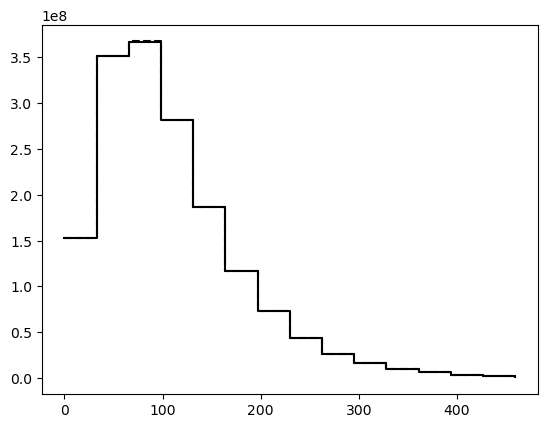

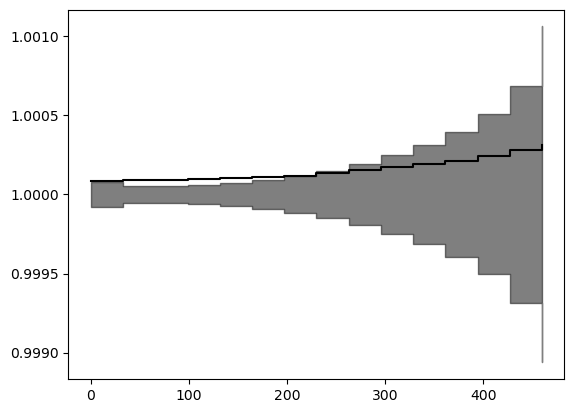

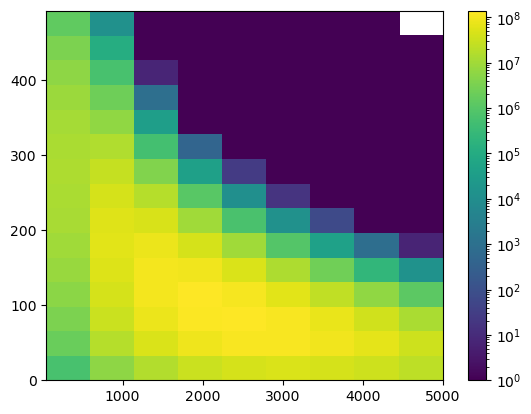

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/255286840.py:15: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(Ebins,Rbins,(nue_rates_per_bin[(experiment,"LV")]/nue_rates_per_bin[(experiment,"SM")]).T,vmin=0.99,vmax=1.01,cmap="RdBu")
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/255286840.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


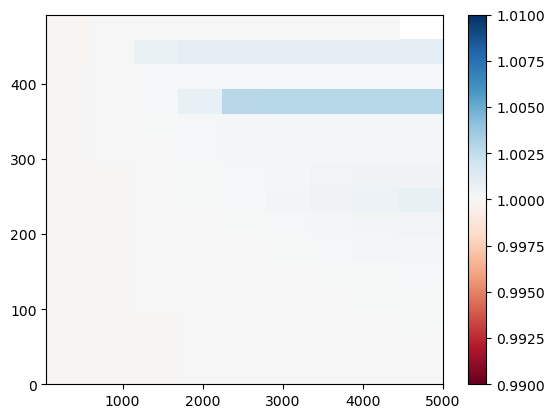

Experiment:  IC


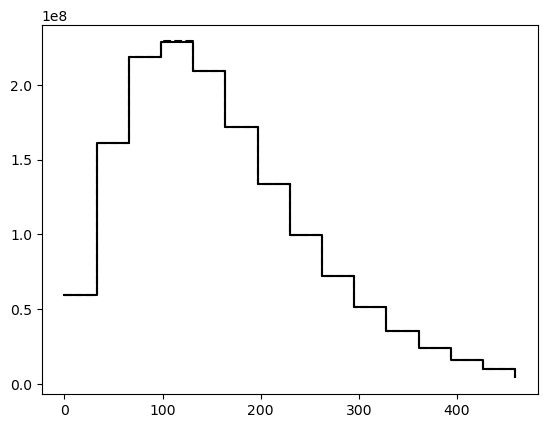

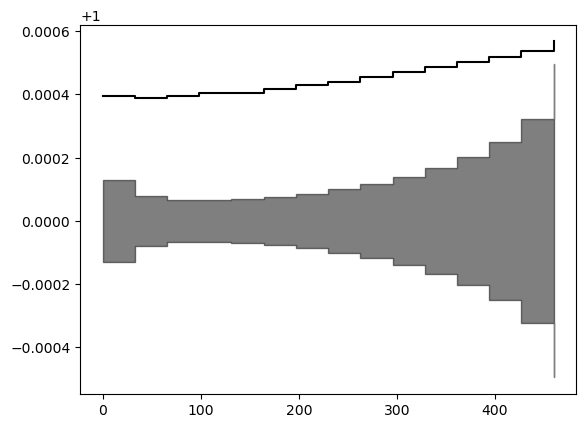

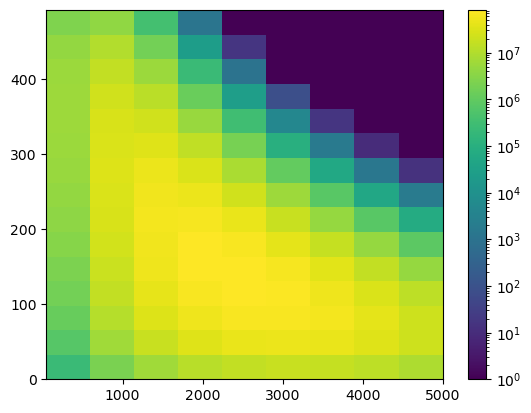

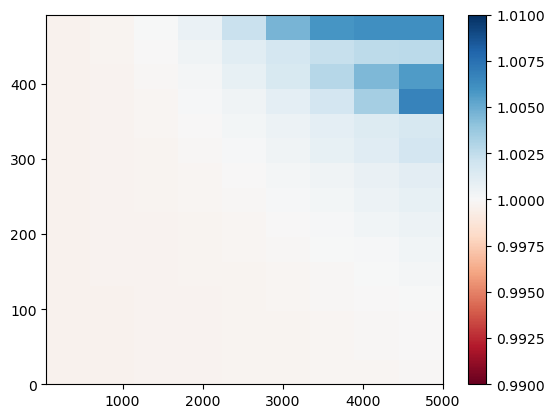

Experiment:  PONE


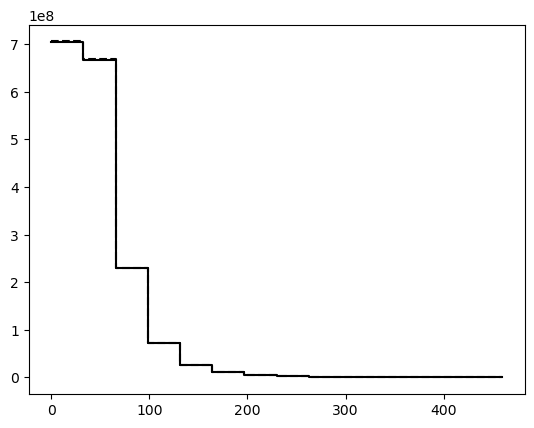

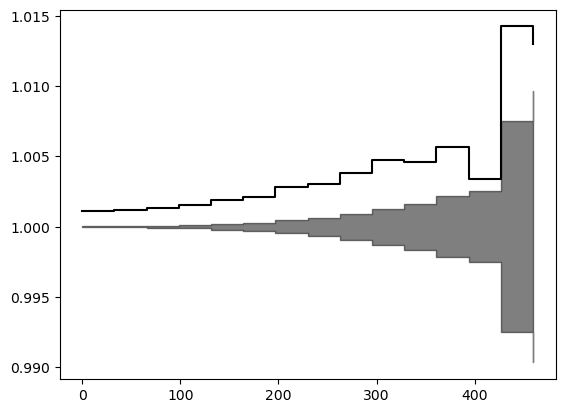

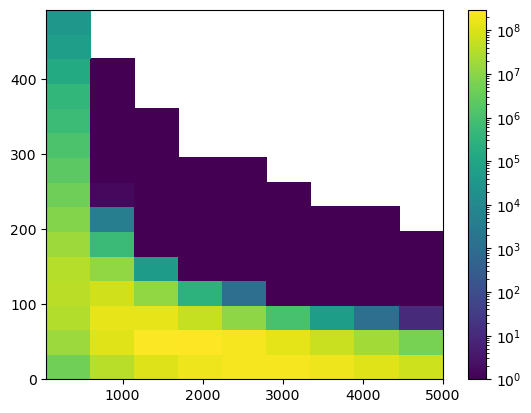

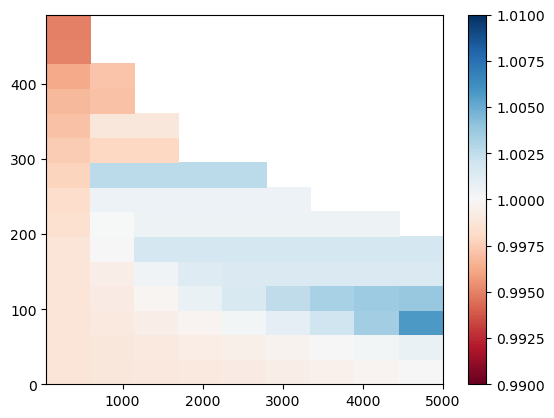

In [18]:
for experiment in experiment_list:
    print("Experiment: ",experiment)
    N = best_fit_N(nue_rates_per_bin[(experiment,"LV")],nue_rates_per_bin[(experiment,"SM")],
                   numu_rates_per_bin[(experiment,"LV")],numu_rates_per_bin[(experiment,"SM")],sigmaN=0.01)
    plt.step(Rbins[:-1],numu_rates_per_bin[(experiment,"SM")],color="black",where="post")
    plt.step(Rbins[:-1],numu_rates_per_bin[(experiment,"LV")],color="black",where="post",ls="--")
    plt.show()
    plt.step(Rbins[:-1],numu_rates_per_bin[(experiment,"LV")]/numu_rates_per_bin[(experiment,"SM")],color="black",where="post")
    stat_unc = 1./np.sqrt(numu_rates_per_bin[(experiment,"SM")])
    plt.fill_between(Rbins[:-1],N-stat_unc,N+stat_unc,color="black",alpha=0.5,step="post")
    plt.show()
    plt.pcolor(Ebins,Rbins,(nue_rates_per_bin[(experiment,"SM")]).T,norm=LogNorm(vmin=1e0))
    plt.colorbar()
    plt.show()
    plt.pcolor(Ebins,Rbins,(nue_rates_per_bin[(experiment,"LV")]/nue_rates_per_bin[(experiment,"SM")]).T,vmin=0.99,vmax=1.01,cmap="RdBu")
    plt.colorbar()
    plt.show()

# Below here is trash

In [19]:
neval=10000
nitn_warmup=10
nitn=10
reco_distributions = {}

for exp in experiment_list:
    reco_distributions[(exp,"nueSM")] = np.zeros((len(Ebins),len(Rbins)))
    reco_distributions[(exp,"nueLV")] = np.zeros((len(Ebins),len(Rbins)))
    reco_distributions[(exp,"numuSM")] = np.zeros(len(Rbins))
    reco_distributions[(exp,"numuLV")] = np.zeros(len(Rbins))
    
for iR in range(len(Rbins)-1):
    print(iR)
    numu_integ = vegas.Integrator(
        [
            [Ebins[0],Ebins[-1]],
            [Rbins[iR],Rbins[iR+1]],
        ]
    )
    w = numu_integ(numu_integrand, nitn=nitn_warmup, neval=neval)
    result_numu = numu_integ(numu_integrand, nitn=nitn, neval=neval)
    for experiment in experiment_list:
        reco_distributions[(experiment,"numuSM")][iR] = result_numu[(experiment,"SM")].mean
        reco_distributions[(experiment,"numuLV")][iR] = result_numu[(experiment,"LV")].mean
    for iE in range(len(Ebins)-1):
        nue_integ = vegas.Integrator(
            [
                [Ebins[iE],Ebins[iE+1]],
                [Rbins[iR],Rbins[iR+1]],
                [Enu[0],Enu[-1]],
                #[Rs[0],Rs[-1]]
            ]
        )
        w = nue_integ(nue_integrand, nitn=nitn_warmup, neval=neval)
        try:
            result_nue = nue_integ(nue_integrand, nitn=nitn, neval=neval)
            for experiment in experiment_list:
                reco_distributions[(experiment,"nueSM")][iE,iR] = result_nue[(experiment,"SM")].mean
                reco_distributions[(experiment,"nueLV")][iE,iR] = result_nue[(experiment,"LV")].mean
        except:
            for experiment in experiment_list:
                reco_distributions[(experiment,"nueSM")][iE,iR] = 0
                reco_distributions[(experiment,"nueLV")][iE,iR] = 0

0
1
2
3
4
5
6
7


/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1088620782.py:34: RuntimeWarning: overflow encountered in divide
  w = nue_integ(nue_integrand, nitn=nitn_warmup, neval=neval)


8


/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1088620782.py:36: RuntimeWarning: overflow encountered in divide
  result_nue = nue_integ(nue_integrand, nitn=nitn, neval=neval)


9
10
11
12
13
14


KM3


/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/4185396013.py:4: RuntimeWarning: divide by zero encountered in divide
  reco_distributions[(experiment,"nueLV")][:-1,:-1].T / reco_distributions[(experiment,"nueSM")][:-1,:-1].T,
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/4185396013.py:4: RuntimeWarning: invalid value encountered in divide
  reco_distributions[(experiment,"nueLV")][:-1,:-1].T / reco_distributions[(experiment,"nueSM")][:-1,:-1].T,
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/4185396013.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


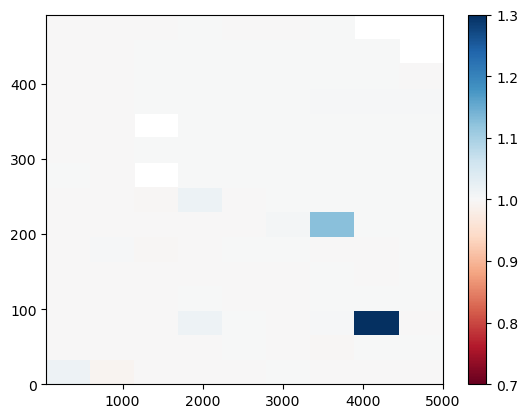

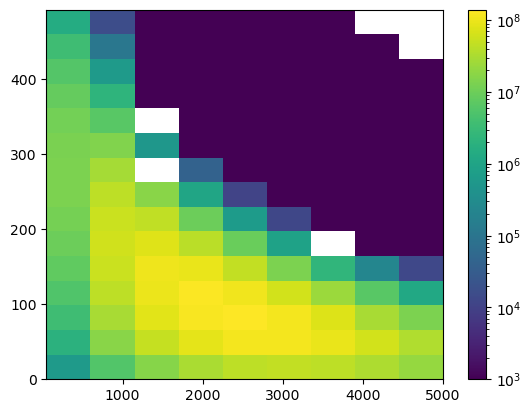

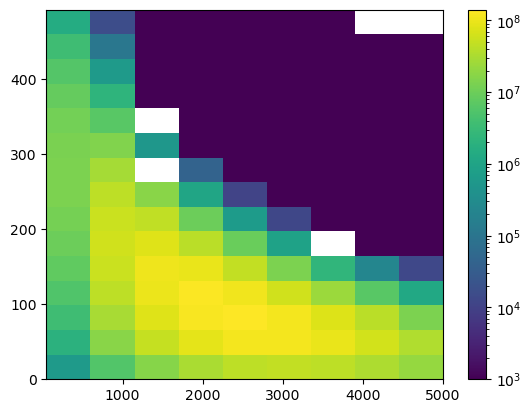

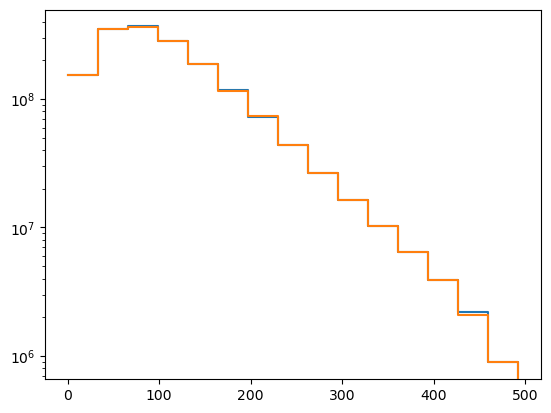

/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/4185396013.py:18: RuntimeWarning: invalid value encountered in divide
  plt.step(Rbins,reco_distributions[(experiment,"numuLV")] / reco_distributions[(experiment,"numuSM")],where="post")


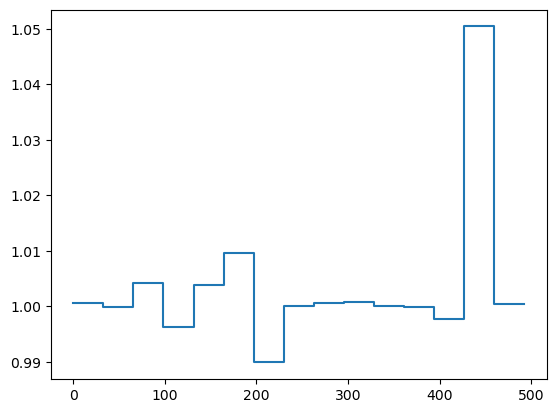

IC


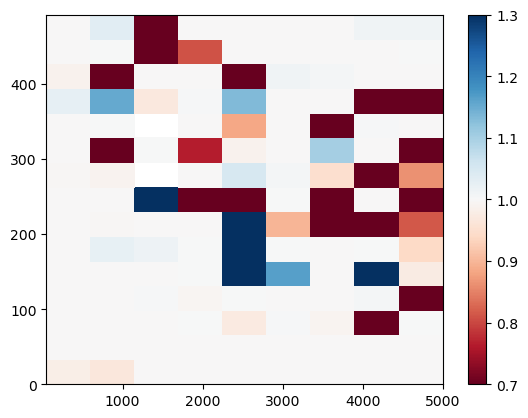

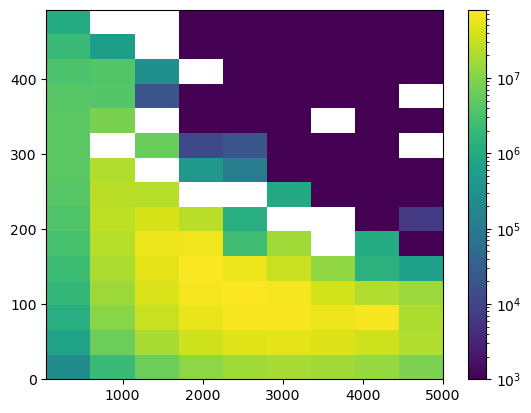

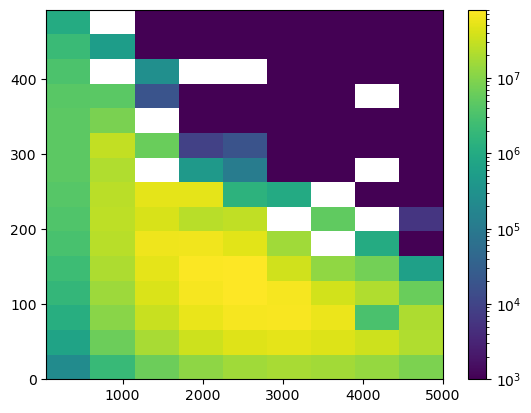

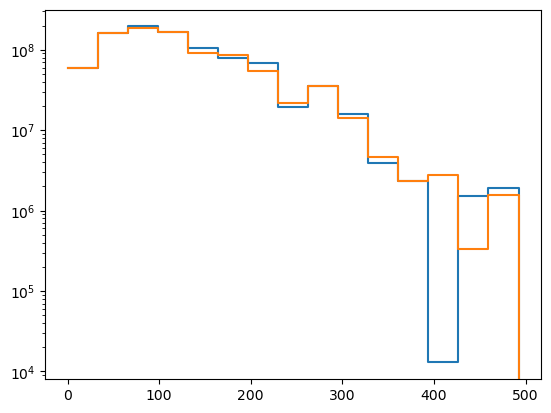

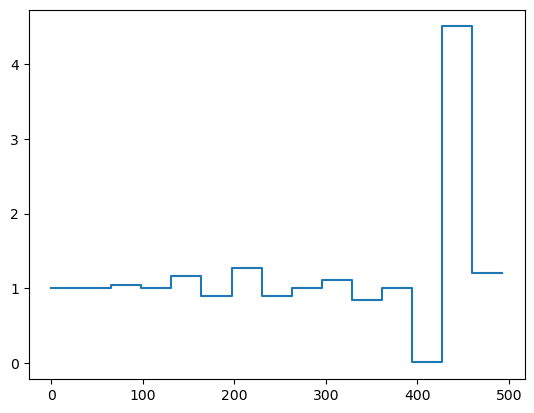

PONE


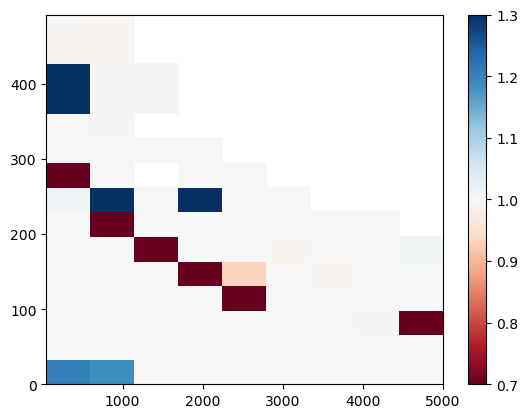

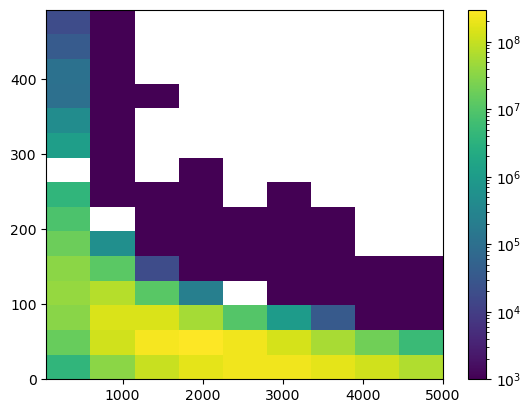

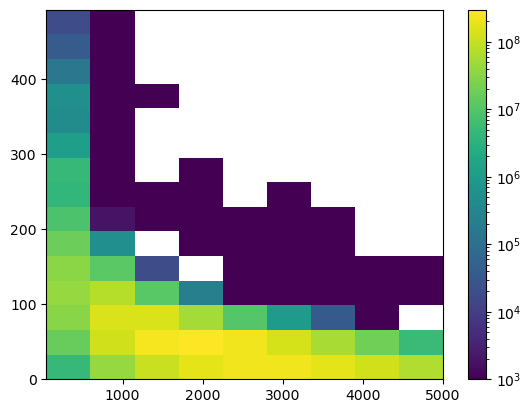

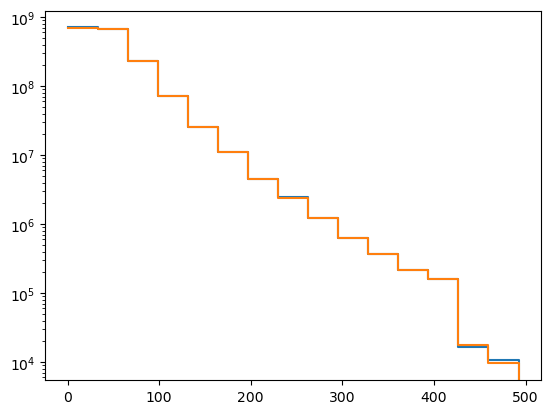

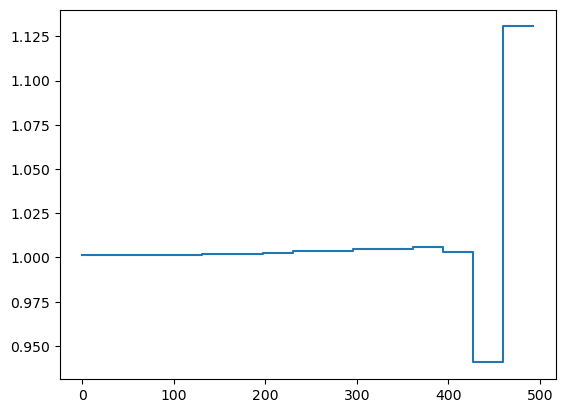

In [20]:
for experiment in experiment_list:
    print(experiment)
    plt.pcolor(Ebins,Rbins,
               reco_distributions[(experiment,"nueLV")][:-1,:-1].T / reco_distributions[(experiment,"nueSM")][:-1,:-1].T,
              vmin=0.7,vmax=1.3,cmap="RdBu")
    plt.colorbar()
    plt.show()
    plt.pcolormesh(Ebins,Rbins,reco_distributions[(experiment,"nueSM")][:-1,:-1].T,norm=LogNorm(vmin=1e3))
    plt.colorbar()
    plt.show()
    plt.pcolormesh(Ebins,Rbins,reco_distributions[(experiment,"nueLV")][:-1,:-1].T,norm=LogNorm(vmin=1e3))
    plt.colorbar()
    plt.show()
    plt.step(Rbins,reco_distributions[(experiment,"numuLV")],where="post")
    plt.step(Rbins,reco_distributions[(experiment,"numuSM")],where="post")
    plt.semilogy()
    plt.show()
    plt.step(Rbins,reco_distributions[(experiment,"numuLV")] / reco_distributions[(experiment,"numuSM")],where="post")
    plt.show()

In [21]:





def mcmc_updater(curr_state, curr_likeli, likelihood):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposal) distribution, `mcmc_updater` generates 
      a new proposal, evaluate its likelihood, compares that to the current 
      likelihood with a uniformly samples threshold, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likeli (float): the current likelihood estimate
        likelihood (function): a function handle to compute the likelihood

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = (np.random.uniform(Enu[0],Enu[-1]),
                      np.random.uniform(Rs[0],Rs[-1]))

    # Calculate the acceptance criterion
    prop_likeli = likelihood(proposal_state)
    accept_crit = prop_likeli / curr_likeli

    # Generate a random number between 0 and 1
    accept_threshold = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if accept_crit > accept_threshold:
        return proposal_state, prop_likeli

    # Else
    return curr_state, curr_likeli

def metropolis_hastings(
        likelihood, initial_state, 
        num_samples, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(
            curr_state=curr_state,
            curr_likeli=curr_likeli,
            likelihood=likelihood,
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

    return np.array(samples)

print(numubar_interp_total_rates_SM)
n_samples = int(1e5)
numubar_samples_SM = metropolis_hastings(numubar_interp_rates_per_energy_radius_SM["PONE"],(Enu[0],Rs[0]),n_samples)
nue_samples_SM = metropolis_hastings(nue_interp_rates_per_energy_radius_SM["PONE"],(Enu[0],Rs[0]),n_samples)
numubar_samples_LV = metropolis_hastings(numubar_interp_rates_per_energy_radius_LV["PONE"],(Enu[0],Rs[0]),n_samples)
nue_samples_LV = metropolis_hastings(nue_interp_rates_per_energy_radius_LV["PONE"],(Enu[0],Rs[0]),n_samples)


{}


/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1397630246.py:27: RuntimeWarning: invalid value encountered in divide
  accept_crit = prop_likeli / curr_likeli
/var/folders/sh/mdzkh6vs0bl6zwrc7bjzk4h40000gn/T/ipykernel_24802/1397630246.py:27: RuntimeWarning: divide by zero encountered in divide
  accept_crit = prop_likeli / curr_likeli


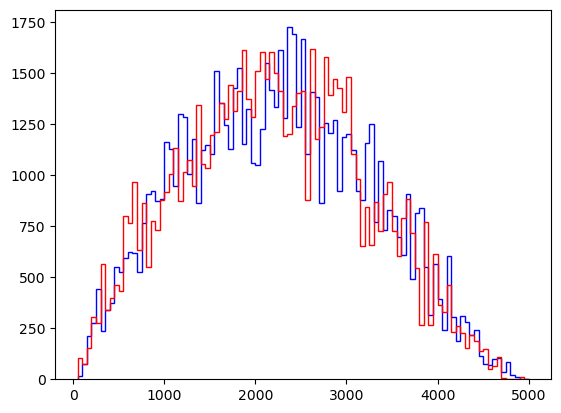

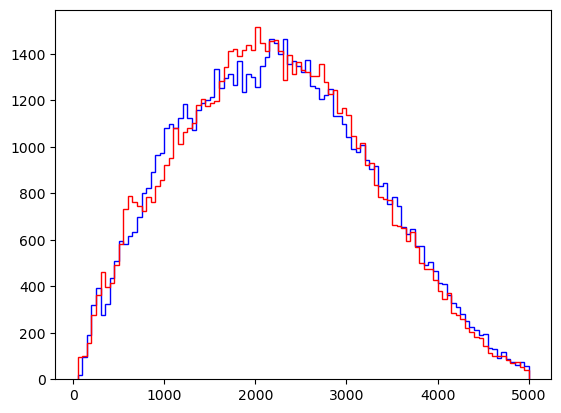

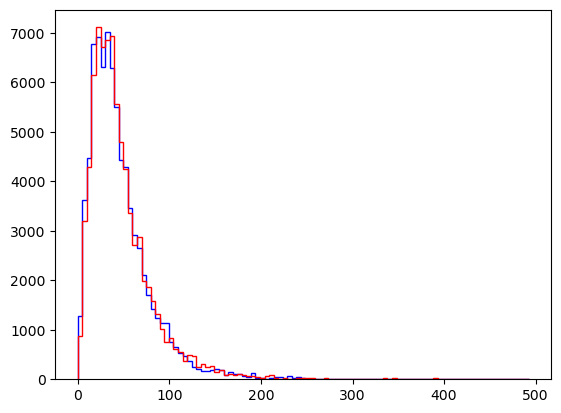

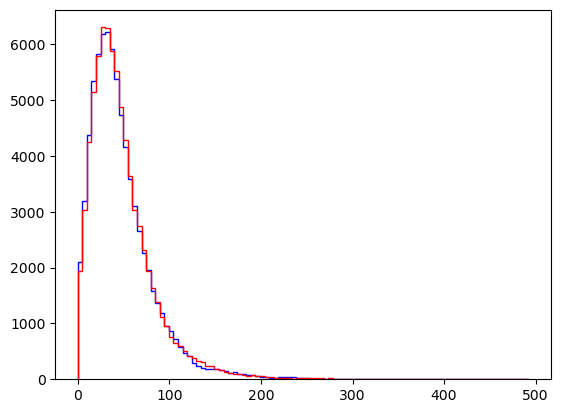

In [22]:


# nue
SM_samples = nue_samples_SM
LV_samples = nue_samples_LV
unc = 0.1
    
reco_energies_SM = np.random.normal(loc=SM_samples[:,0],scale=unc*SM_samples[:,0])
reco_radii_SM = np.random.normal(loc=SM_samples[:,1],scale=10)
reco_samples_SM = np.transpose([reco_energies_SM,reco_radii_SM])

reco_energies_LV = np.random.normal(loc=LV_samples[:,0],scale=unc*LV_samples[:,0])
reco_radii_LV = np.random.normal(loc=LV_samples[:,1],scale=10)
reco_samples_LV = np.transpose([reco_energies_LV,reco_radii_LV])

# plt.hist2d(SM_samples[:,0],SM_samples[:,1],bins=(Enu,Rs))
# plt.colorbar()
# plt.show()
# plt.hist2d(reco_samples_SM[:,0],reco_samples_SM[:,1],bins=(Enu,Rs))
# plt.colorbar()
# plt.show()
SM,_,_ = plt.hist(SM_samples[:,0],bins=Enu,histtype="step",color="blue")
LV,_,_ = plt.hist(LV_samples[:,0],bins=Enu,histtype="step",color="red")
plt.show()
SM_reco,_,_ = plt.hist(reco_samples_SM[:,0],bins=Enu,histtype="step",color="blue")
LV_reco,_,_ = plt.hist(reco_samples_LV[:,0],bins=Enu,histtype="step",color="red")
plt.show()

SM,_,_ = plt.hist(SM_samples[:,1],bins=Rs,histtype="step",color="blue")
LV,_,_ = plt.hist(LV_samples[:,1],bins=Rs,histtype="step",color="red")
plt.show()
SM_reco,_,_ = plt.hist(reco_samples_SM[:,1],bins=Rs,histtype="step",color="blue")
LV_reco,_,_ = plt.hist(reco_samples_LV[:,1],bins=Rs,histtype="step",color="red")
plt.show()

# plt.hist(samples[:,1],bins=Rs,histtype="step")
# plt.hist(reco_samples[:,1],bins=Rs,histtype="step")
# plt.show()

In [23]:


nbins = 20
Er_bins = np.linspace(Emuon/10,Emuon,nbins)
Rr_bins = np.linspace(0,RADIUS,nbins)

# Initialize an array to store integral results
numubar_reco_rates_per_bin_SM = {}
numubar_reco_rates_per_bin_LV = {}
nue_reco_rates_per_bin_SM = {}
nue_reco_rates_per_bin_LV = {}


for experiment in experiment_list:
    print(experiment)

    numubar_reco_diff_rate_per_energy_radius_SM = lambda Er,Rr: dblquad(lambda Et,Rt : numubar_interp_rates_per_energy_radius_SM[experiment]((Et,Rt)) * NumuEnergySmearing(Er,Et) * PositionSmearing(Rr,Rt),
                                                                        Rs[0],Rs[-1],
                                                                        Enu[0], Enu[-1])
    numubar_reco_diff_rate_per_energy_radius_LV = lambda Er,Rr: dblquad(lambda Et,Rt : numubar_interp_rates_per_energy_radius_LV[experiment]((Et,Rt)) * NumuEnergySmearing(Er,Et) * PositionSmearing(Rr,Rt),
                                                                        Rs[0],Rs[-1],
                                                                        Enu[0], Enu[-1])
    nue_reco_diff_rate_per_energy_radius_SM = lambda Er,Rr: dblquad(lambda Et,Rt : nue_interp_rates_per_energy_radius_SM[experiment]((Et,Rt)) * NueEnergySmearing(Er,Et) * PositionSmearing(Rr,Rt),
                                                                        Rs[0],Rs[-1],
                                                                        Enu[0], Enu[-1])
    nue_reco_diff_rate_per_energy_radius_LV = lambda Er,Rr: dblquad(lambda Et,Rt : nue_interp_rates_per_energy_radius_SM[experiment]((Et,Rt)) * NueEnergySmearing(Er,Et) * PositionSmearing(Rr,Rt),
                                                                        Rs[0],Rs[-1],
                                                                        Enu[0], Enu[-1])
    

    numubar_reco_rates_per_bin_SM[experiment] = np.zeros((len(Er_bins) - 1, len(Rr_bins) - 1))
    numubar_reco_rates_per_bin_LV[experiment] = np.zeros((len(Er_bins) - 1, len(Rr_bins) - 1))
    nue_reco_rates_per_bin_SM[experiment] = np.zeros((len(Er_bins) - 1, len(Rr_bins) - 1))
    nue_reco_rates_per_bin_LV[experiment] = np.zeros((len(Er_bins) - 1, len(Rr_bins) - 1))

    # Iterate over each bin and calculate the integral
    for i in range(len(Er_bins) - 1):
        print(i)
        for j in range(len(Rr_bins) - 1):
            x_lower, x_upper = Er_bins[i], Er_bins[i+1]
            y_lower, y_upper = Rr_bins[j], Rr_bins[j+1]
    
            numubar_reco_rates_per_bin_SM[experiment][i, j], _ = dblquad(numubar_reco_diff_rate_per_energy_radius_SM,
                                                                         y_lower, y_upper, 
                                                                         x_lower,  x_upper)
            numubar_reco_rates_per_bin_LV[experiment][i, j], _ = dblquad(numubar_reco_diff_rate_per_energy_radius_LV,
                                                                         y_lower, y_upper, 
                                                                         x_lower,  x_upper)
            nue_reco_rates_per_bin_SM[experiment][i, j], _ = dblquad(nue_reco_diff_rate_per_energy_radius_SM,
                                                                     y_lower, y_upper, 
                                                                     x_lower,  x_upper)
            nue_reco_rates_per_bin_LV[experiment][i, j], _ = dblquad(nue_reco_diff_rate_per_energy_radius_LV,
                                                                     y_lower, y_upper, 
                                                                     x_lower,  x_upper)

KM3
0


/Users/nickkamp/anaconda3/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nickkamp/anaconda3/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


TypeError: must be real number, not tuple

In [ ]:
for experiment in experiment_list:
    numubar_ratio = numubar_rates_per_energy_radius_LV[experiment]/numubar_rates_per_energy_radius_SM[experiment]
    nue_ratio = nue_rates_per_energy_radius_LV[experiment]/nue_rates_per_energy_radius_SM[experiment]
    print(experiment)
    plt.pcolormesh(Enu,Rs,numubar_ratio.T,norm=LogNorm(vmax=1.01),cmap="plasma")
    plt.colorbar()
    plt.show()
    plt.pcolormesh(Enu,Rs,nue_ratio.T,norm=LogNorm(vmax=1.01),cmap="plasma")
    plt.colorbar()
    plt.show()